# Plotting ChIP signal in windows around TSS of DEGs after 24h NipBL depletion

***Purpose:*** Investigating relationship between differential expression due to depletion of NipBL and interesting proteins that are involved in 3D genome folding. We are plotting the ChIP signal near the TSS of protein-coding genes. We focus on specific categories, as separated by up-regulated genes, down-regulated genes, and non-significantly dysregulated genes (for comparison)

**proteins of interest:**
* CTCF
* RAD21 
* nipbl
* ring1b
* H3K27Ac 

Assuming: anything not in the final 1-day significant results table have no significant dysregulation `EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv` 

In [1]:
import plotting_heatmap_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Prepare data

In [3]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
feature_counts = '20220816_featureCounts.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

In [4]:
# import results table
day1_res_df = pd.read_csv(proj+day1_sigRes)

# add feature counts information to label genes not in the significant results table
feat_counts_df = pd.read_csv(proj+feature_counts)
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

### Adding TSS coordinate locations from genomic annotation file

Getting the TSS for the genes in this set

Remove any genes mapped to chrX before proceeding (save for later analysis)

In [5]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  0


In [6]:
day1_res_df = flt.label_DE_status(day1_res_df)

Where is ChIP relative to dysregulated genes? 

Interesting proteins: For Rad21? For CTCF? For Nipbl? Polycomb proteins (RING1B, SUZ12)?

### Import ChIP-seq files

In [7]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [10]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

### measure ChIP signal over TSS intervals

In [11]:
chip_seq_condition_matrix_dict = pfn.generate_signal_matrix_parallel(day1_res_df, chip_seq_condition_dict)

# Plot ChIP signal around +/- 1000bp of TSS of genes for all proteins of interest

Plotting for each protein:
 - log2Fold Expression level of DEGSs
 - ChIP signal for all proteins around +/- 1000 bp of TSS for those DEGs
 - average ChIP signal around +/- 1000 bp of TSS for all genes

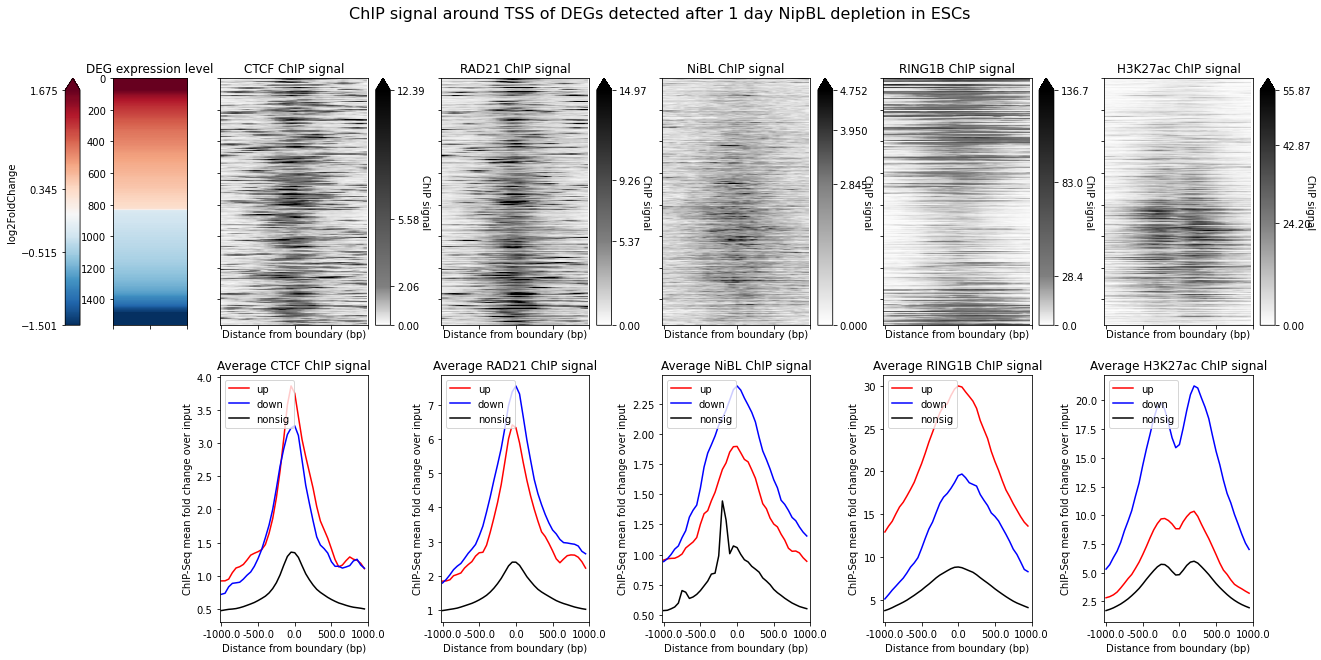

In [12]:
num_conditions = len(chip_seq_condition_dict)
num_deg_sets = 1
widths = [0.1, 0.5]*num_deg_sets+[1, 0.05]*num_conditions

fig = plt.figure(figsize=(22, 10))
fig.suptitle(('ChIP signal around TSS of DEGs '
             'detected after 1 day NipBL depletion in ESCs'),
             fontsize=16)
gs0 = gridspec.GridSpec(2, 2*(num_conditions+num_deg_sets), 
                              figure=fig, 
                              width_ratios=widths)

gs0.update(wspace=0.45, hspace=0.2)
#gs00 = gs0[1].subgridspec(2, 4, 'width_ratios'=[.05,1,1,.05])
cax1 = fig.add_subplot(gs0[0, 0])
ax1 = fig.add_subplot(gs0[0, 1])

pfn.plot_category_heatmap(day1_res_df, 
                          plot_title="""DEG expression level""",
                          ax=ax1,
                          cax=cax1
                          )

last_ax = 1
for cond, chip_file in chip_seq_condition_dict.items():
                        
    ax2 = fig.add_subplot(gs0[0, last_ax+1], sharey=ax1)
    cax2 = ax2.inset_axes((1.05,0.0,.1,1.0))
    ax3 = fig.add_subplot(gs0[1, last_ax+1], sharex=ax2)
    last_ax=last_ax+2
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)

    matrix = chip_seq_condition_matrix_dict[cond]

    pfn.plot_binned_signal_heatmap(day1_res_df, 
                                  matrix, 
                                  plot_title=("{} ChIP signal".format(cond)),
                                  ax=ax2,
                                  cax=cax2
                                  )
    
    pfn.plot_avg_signal(day1_res_df, 
                        matrix, 
                        plot_title="Average {} ChIP signal".format(cond),
                        ax=ax3)

plt.savefig('20221012_1day_dNipBL_ChIP_spaced.png')
plt.show()

### measure signal over Window +/- 10kbp

In [13]:
medium_window = 10000
chip_seq_condition_matrix_dict_10kb = pfn.generate_signal_matrix_parallel(day1_res_df, chip_seq_condition_dict, window_size=medium_window)

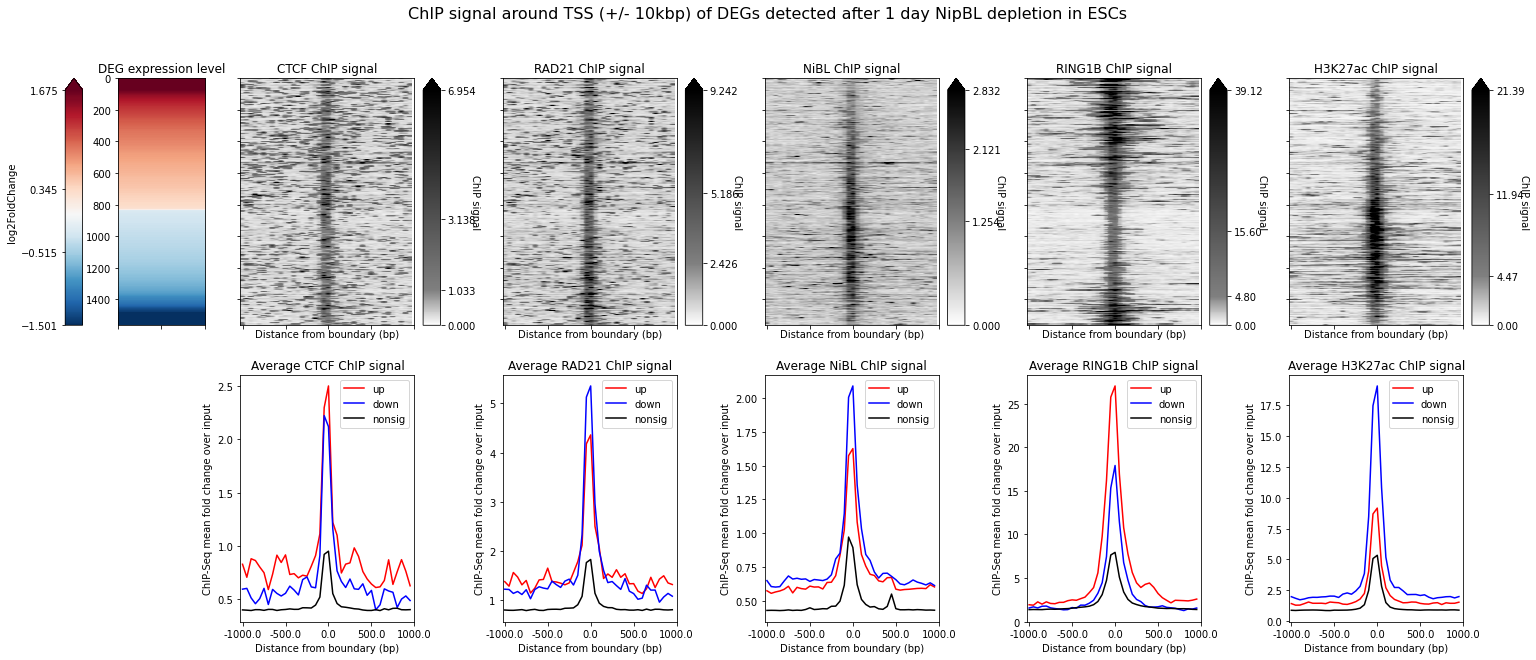

In [15]:
num_conditions = len(chip_seq_condition_dict)
num_deg_sets = 1
widths = [0.1, 0.5]*num_deg_sets+[1, 0.1]*num_conditions

fig = plt.figure(figsize=(26, 10))
fig.suptitle(('ChIP signal around TSS (+/- 10kbp) of DEGs '
             'detected after 1 day NipBL depletion in ESCs'),
             fontsize=16)
gs0 = gridspec.GridSpec(2, 2*(num_conditions+num_deg_sets), 
                              figure=fig, 
                              width_ratios=widths)

gs0.update(wspace=0.4, hspace=0.2)
#gs00 = gs0[1].subgridspec(2, 4, 'width_ratios'=[.05,1,1,.05])
cax1 = fig.add_subplot(gs0[0, 0])
ax1 = fig.add_subplot(gs0[0, 1])

pfn.plot_category_heatmap(day1_res_df, 
                          plot_title="""DEG expression level""",
                          ax=ax1,
                          cax=cax1
                          )

last_ax = 1
for cond, chip_file in chip_seq_condition_dict.items():
                        
    ax2 = fig.add_subplot(gs0[0, last_ax+1], sharey=ax1)
    cax2 = ax2.inset_axes((1.05,0.0,.1,1.0))
    ax3 = fig.add_subplot(gs0[1, last_ax+1], sharex=ax2)
    last_ax=last_ax+2
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)

    matrix = chip_seq_condition_matrix_dict_10kb[cond]

    pfn.plot_binned_signal_heatmap(day1_res_df, 
                                  matrix, 
                                  plot_title=("{} ChIP signal".format(cond)),
                                  ax=ax2,
                                  cax=cax2
                                  )
    
    pfn.plot_avg_signal(day1_res_df, 
                        matrix, 
                        plot_title="Average {} ChIP signal".format(cond),
                        ax=ax3)

plt.savefig('20221012_1day_dNipBL_ChIP_spaced_10kb.png')
plt.show()